In [62]:
import numpy as np
import scipy.linalg as la
import math
import matplotlib.pyplot as plt
import time
import random

$f(w) =  \dfrac{1}{n}\sum\limits_{i=1}^n \ln(1+\exp(-w^Tx_iy_i)) + \dfrac{\lambda}{2}\|w\|^2$

$\nabla f (w) =  -\dfrac{1}{n}\sum\limits_{i=1}^n \dfrac{1}{1 + e^{w^Tx_iy_i}}x_iy_i + \lambda w$

$\nabla^2 f(w) = \dfrac{1}{n}\sum\limits_{i=1}^n \dfrac{e^{w^Tx_iy_i}}{(1 + e^{w^Tx_iy_i})^2}(x_ix_i^T) y_i^2 + \lambda I$

In [91]:
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

dataset = "mushrooms.txt"
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]

y = 2 * y - 3
n, d = X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)
n_train = X_train.shape[0]

L = 5.25
lambd = L/100
x0 = np.random.uniform(low=-L/5, high=L/5, size=(d,))

In [124]:
from numba import jit
import warnings
warnings.filterwarnings("ignore")

@jit
def fi(x, i):
    return np.log(1 + np.exp(-x.T @ (y_train[i] * X_train[i].T))) + lambd/2 * np.linalg.norm(x, ord=2)**2

@jit
def gradi(x, i):
    return -y_train[i]/(1 + np.exp(x.T @  (X_train[i].T * y_train[i]))) * X_train[i] + lambd * x

@jit
def f(x):
    a = 0
    for i in range(n_train):
        a += fi(x, i)
    a = a/n_train
    return a

@jit
def grad(x):
    a = np.zeros(d)
    for i in range(n_train):
        a += gradi(x, i)
    a = a/n_train
    return a

def nongrad(x, t):
    g = [0 for _ in range(d)]
    for i in range(d):
        e = [0  for _ in range(d)]
        e[i] = 1
        e = np.array(e)
        g[i] = float(f(x + t * e) - f(x - t * e)) / (2 * t)
    return (np.array(g))

In [135]:
def GD(x0, gamma, iters=500, approx=False, t=0):
    
    x = x0
    acc = []
    times = []
    start = time.time()

    for k in range(iters):
        if approx:
            x = x - gamma(k) * nongrad(x, t)
        else:
            x = x - gamma(k) * grad(x)
        times.append(time.time() - start)
        if k % 10 == 0:
            acc.append(accuracy_score(y_test, np.around(2 / (1 + np.exp(- X_test @ x))) - 1))

    return times, acc, x

In [136]:
iters = 3000
times1, acc1, x1 = GD(x0, gamma=lambda k: 0.3, iters=iters)
#acc2, x2 = GD(x0, gamma=lambda k: 0.3, iters=iters, approx=True, t=0.0001)

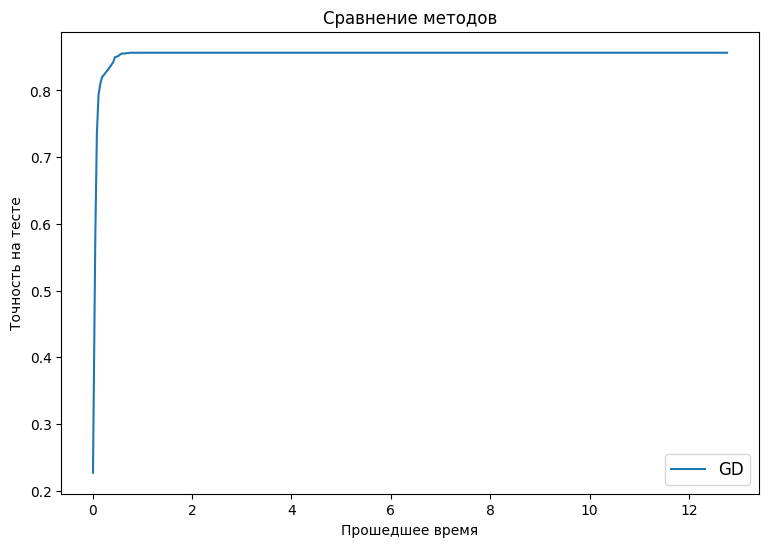

In [137]:
plt.figure(figsize=(9, 6))
plt.plot(times1[::10], acc1, label="GD")
plt.xlabel("Прошедшее время")
plt.ylabel("Точность на тесте")
plt.title('')
plt.legend(fontsize=12)
plt.show()